In [1]:

import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz
import os
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.contrib.examples.util  # patches torchvision
from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from IPython.display import clear_output

gp_fig_folder = "../report/figures/gp/"

os.makedirs(os.path.dirname(gp_fig_folder), exist_ok=True)


/home/pants007/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


# B.1

## Data

In [2]:
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = f(X)
x = torch.tensor([-1/4])
XNew = torch.linspace(-1, 1, steps=200)

## Gaussian process definition

In [3]:
def make_gpr(X,y, default = True, kernel = None, prior_dict = None):
    pyro.clear_param_store()
    if default:
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
    else:
        assert kernel is not None
        assert isinstance(prior_dict, dict)
        for attr,prior in prior_dict.items():
            setattr(kernel, attr, prior)
    return gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10**(-4)))

## MCMC hyper-parameters

In [4]:
C = 4
W = 100
N = 500
#C = 2
#W = 1
#N = 4

## Sampling posterior of GP with MCMC

In [5]:
def mcmc_sampler(gpr, C, W, N):
    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile = True, ignore_jit_warnings=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=N,
                        num_chains=C, warmup_steps = W)
    mcmc.run()
    return mcmc

In [6]:
gpr = make_gpr(X, y)
mcmc = mcmc_sampler(gpr, C, W, N)

Warmup [1]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/600 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/600 [00:00, ?it/s]

## Estimates of mean and variance based on samples

In [7]:
def predictive(x, gpr, prior_dict = None):
    if prior_dict is None:
        gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
        gpr.kernel.lengthscale = pyro.nn.module.PyroSample(dist.LogNormal(-1.0, 1.0))
    else:
        assert isinstance(prior_dict, dict)
        for attr,prior in prior_dict.items():
            setattr(gpr.kernel, attr, prior)
    loc, cov = gpr(x, noiseless = False, full_cov = True)
    var = cov.diag()
    pyro.sample("loc", dist.Delta(loc))
    pyro.sample("var", dist.Delta(var))
    pyro.sample("f", dist.Normal(loc, var))

In [8]:
def sample_predict(x, gpr, mcmc, default = True, prior_dict = None):
    posterior_samples=mcmc.get_samples(group_by_chain=True)
    posterior_samples_flat = {k : v.flatten() for (k,v) in posterior_samples.items()}
    posterior_predictor = pyro.infer.Predictive(predictive, posterior_samples = posterior_samples_flat)
    posterior_predictive = posterior_predictor(x,gpr, prior_dict)
    return posterior_predictive, posterior_samples

In [9]:
posterior_predictive, posterior_samples = sample_predict(XNew, gpr, mcmc)
posterior_locs = posterior_predictive['loc']
posterior_vars = posterior_predictive['var']
print(posterior_locs.shape, posterior_vars.shape)
posterior_lengthscale = posterior_samples['kernel.lengthscale']
posterior_variance = posterior_samples['kernel.variance']

torch.Size([2000, 200]) torch.Size([2000, 200])


## A scatter plot on log-log scale of N = 500 samples from $P(\theta | \mathcal{D})$

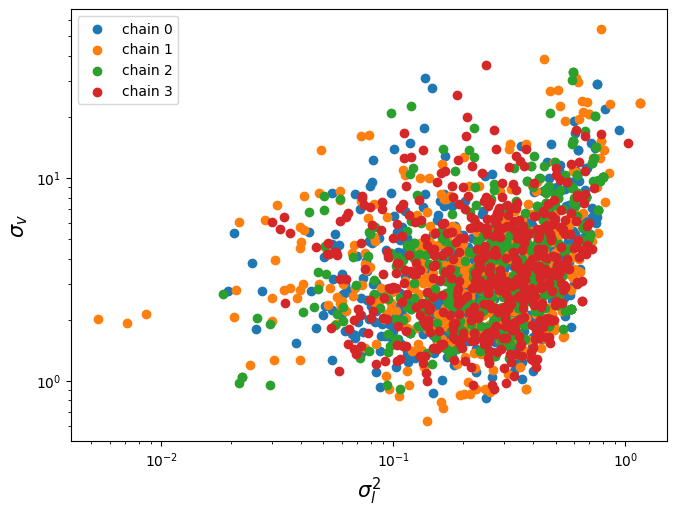

In [10]:
for c in range(C):
    plt.scatter(posterior_lengthscale[c],posterior_variance[c], label = "chain " + str(c))
plt.xlabel(r"$\sigma_l^2$", fontsize = 15)
plt.ylabel(r"$\sigma_v$", fontsize=15)
plt.yscale("log")
plt.xscale("log")
plt.legend()
slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.savefig(gp_fig_folder + "loglogscale.pdf",
            bbox_inches="tight")
plt.show()

## Sample quality analysis

/home/pants007/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/pants007/.local/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.305  0.181     0.021      0.651      0.008    0.006   
kernel.variance     4.477  4.141     0.733     11.457      0.196    0.138   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     450.0     600.0    1.0  
kernel.variance        657.0     494.0    1.0  


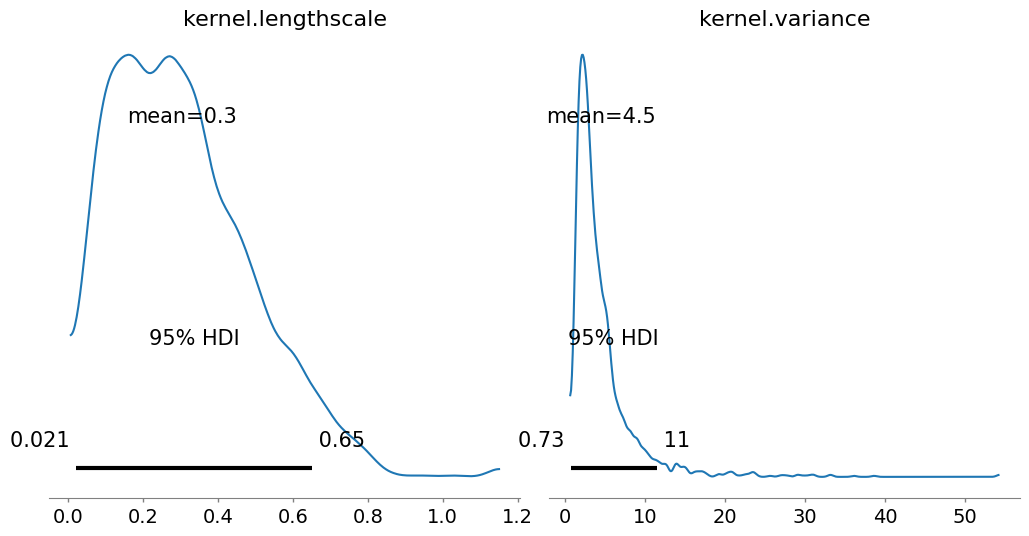

In [11]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data, hdi_prob=0.95)
print(summary)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
arviz.plot_posterior(data, hdi_prob=0.95, ax=axs)
slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.savefig(gp_fig_folder + "sample_analysis.pdf",
            bbox_inches="tight")
plt.show()


## Plot visualizing $p(f^* | x^*, \mathcal{D})$

torch.Size([200])


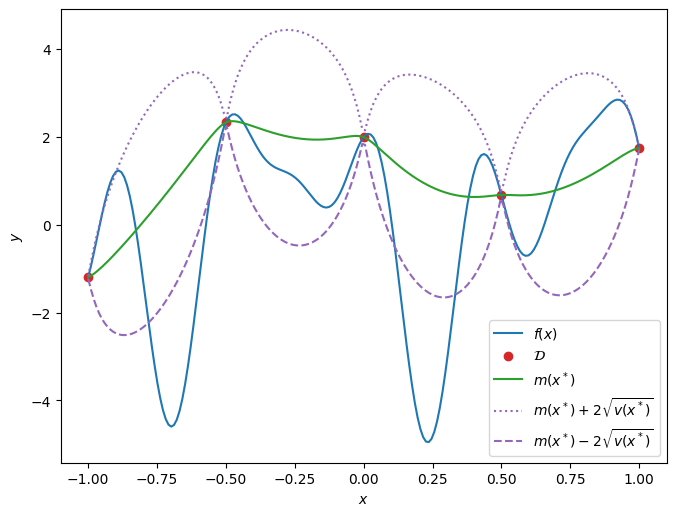

In [12]:
plt.plot(XNew, f(XNew), label = r"$f(x)$")
plt.scatter(X, y, color = 'tab:red', label = r"$\mathcal{D}$")
print(posterior_locs.mean(dim=0).shape)
plt.plot(XNew, posterior_locs.mean(dim=0), color = 'tab:green', label = r"$m(x^*)$")
plt.plot(XNew, posterior_locs.mean(dim=0) + 2*np.sqrt(posterior_vars.mean(dim=0)), color='tab:purple', linestyle='dotted', label=r"$m(x^*) + 2\sqrt{v(x^*)}$")
plt.plot(XNew, posterior_locs.mean(dim=0) -2*np.sqrt(posterior_vars.mean(dim=0)), color='tab:purple', linestyle='dashed', label=r"$m(x^*) -2\sqrt{v(x^*)}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.savefig(gp_fig_folder + "p(f*|x*,D).pdf",
            bbox_inches="tight")
plt.show()

# B.2

## Algorithm definition

In [13]:
def algorithm1(X, y, XNew, T, C=C, W=W, N = N, prior_dict = None, kernel = None):
    X_aug = torch.cat((X, torch.empty(T)))
    y_aug = torch.cat((y, torch.empty(T)))
    X_dim = X.shape[0]
    y_dim = y.shape[0]
    stats = torch.empty((T, 3, XNew.shape[0]))
    minima = torch.empty((T, 2))
    mcmc = None
    #clear_output(wait=True)
    for k in range(T):
        pyro.clear_param_store()
        print("Iteration " + str(k+1) + "/" + str(T))
        X_k = X_aug[:X_dim + k]
        y_k = y_aug[:y_dim + k]
        gpr = make_gpr(X_k, y_k, prior_dict = prior_dict, kernel = kernel)
        mcmc = mcmc_sampler(gpr, C, W, N)
        posterior_predictive, _ = sample_predict(XNew, gpr, mcmc, prior_dict = prior_dict)
        fs = posterior_predictive['f'].mean(dim=0)
        ps = torch.argmin(fs)
        X_min = XNew[ps]
        y_min = f(X_min)
        X_aug[X_dim+k] = X_min
        y_aug[y_dim+k] = y_min
        print(posterior_predictive['loc'].mean(dim=0).shape)
        stats[k, 0, :] = posterior_predictive['loc'].mean(dim=0)
        stats[k, 1, :] = posterior_predictive['var'].mean(dim=0)
        stats[k, 2, :] = fs
        minima[k, 0] = X_min
        minima[k, 1] = y_min
    return stats, minima, mcmc

## Algorithm hyper-parameters

In [16]:
T = 10
C = 4
N = 100
W = 100

## B.2-1 plotting

## Plot for $k \in \{1, 5, 10\}$

In [17]:
stats, minima, mcmc = algorithm1(X, y, XNew, T, C, W, N)

def plot_b2(X, XNew, y, stats, minima, k = 0, save_prefix = '', save=False):
    plt.title(r"k = {}".format(k+1))
    plt.plot(XNew, f(XNew), label = r"$f(x)$")
    plt.plot(XNew, stats[k,2,:], label= r"$f^*$")
    plt.plot(XNew, stats[k,0,:] + 2 * np.sqrt(stats[k,1,:]), label=r"$m(x^*) + 2\sqrt{v(x^*)}$", linestyle='dotted', color='tab:purple')
    plt.plot(XNew, stats[k,0,:] - 2 * np.sqrt(stats[k,1,:]), label=r"$m(x^*) - 2\sqrt{v(x^*)}$", linestyle='dashed', color='tab:purple')
    plt.scatter(X, y, color = 'tab:red', label = r"$\mathcal{D}$", zorder=4)
    plt.scatter(minima[k,0], minima[k,1], color = 'tab:green', label = r"$(x^*_p, f(x^*_p))$", zorder=4)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.legend()
    slim=0.6
    plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
    if save:
        plt.savefig(gp_fig_folder + save_prefix+"k={}.pdf".format(k+1), bbox_inches="tight")
    plt.show()

for k in [0, 4, 9]:
    plot_b2(X, XNew, y, stats, minima, k)

Iteration 1/10


Warmup [1]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/200 [00:00, ?it/s]

## Trying different kernels / grid search of priors

### For reiteration, default parameters used for b2

Iteration 1/10


Sample: 100%|██████████| 50/50 [00:01, 28.43it/s, step size=1.06e+00, acc. prob=0.314]


torch.Size([200])
Iteration 2/10


Sample: 100%|██████████| 50/50 [00:01, 38.08it/s, step size=6.09e+00, acc. prob=0.009]


torch.Size([200])
Iteration 3/10


Sample: 100%|██████████| 50/50 [00:01, 34.99it/s, step size=8.12e+00, acc. prob=0.000]


torch.Size([200])
Iteration 4/10


Sample: 100%|██████████| 50/50 [00:01, 37.46it/s, step size=1.24e+00, acc. prob=0.533]


torch.Size([200])
Iteration 5/10


Sample: 100%|██████████| 50/50 [00:01, 38.17it/s, step size=4.96e-01, acc. prob=0.521]


torch.Size([200])
Iteration 6/10


Sample: 100%|██████████| 50/50 [00:01, 36.91it/s, step size=2.67e+00, acc. prob=0.000]


torch.Size([200])
Iteration 7/10


Sample: 100%|██████████| 50/50 [00:03, 14.74it/s, step size=1.87e+00, acc. prob=0.095]


torch.Size([200])
Iteration 8/10


Sample: 100%|██████████| 50/50 [00:02, 21.97it/s, step size=9.67e-01, acc. prob=0.671]


torch.Size([200])
Iteration 9/10


Sample: 100%|██████████| 50/50 [00:01, 39.72it/s, step size=2.05e+00, acc. prob=0.104]


torch.Size([200])
Iteration 10/10


Sample: 100%|██████████| 50/50 [00:01, 29.86it/s, step size=1.11e+00, acc. prob=0.777]


torch.Size([200])


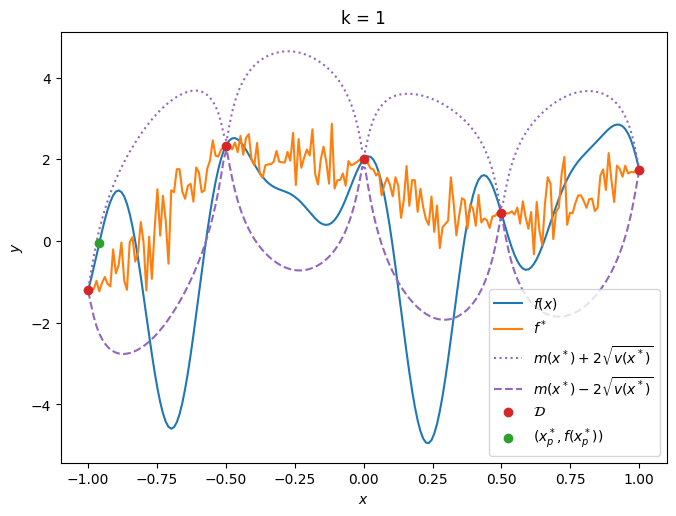

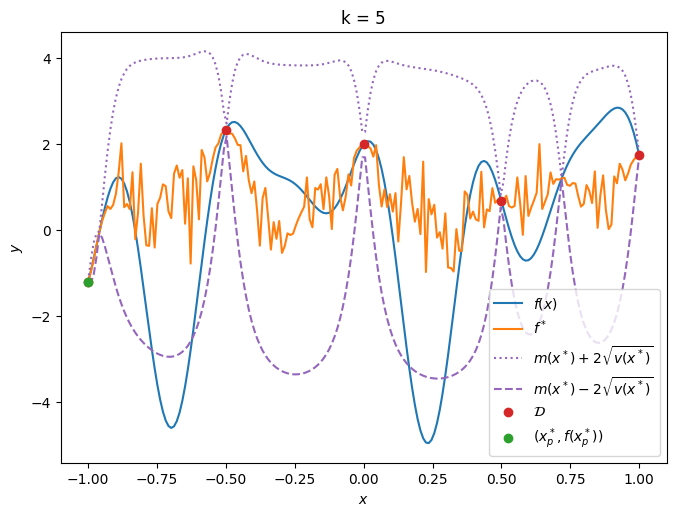

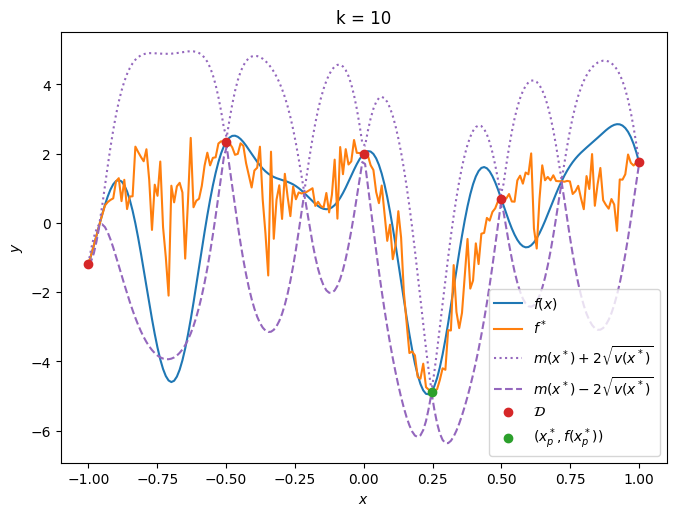

In [ ]:
# prior given in assignment text
prior_dict = {}
prior_dict['variance'] = pyro.nn.PyroSample(dist.LogNormal(0., 1.5))
prior_dict['lengthscale'] = pyro.nn.PyroSample(dist.LogNormal(-1., 1.))
kernel = gp.kernels.RBF(input_dim=1)

stats, minima, mcmc = algorithm1(X, y, XNew, T, C, W, N, prior_dict=prior_dict, kernel=kernel)
for k in [0, 4, 9]:
    plot_b2(X, XNew, y, stats, minima, k)

### Brownian kernel

Iteration 1/10


Sample: 100%|██████████| 50/50 [00:01, 35.10it/s, step size=8.81e-01, acc. prob=0.646]


torch.Size([200])
Iteration 2/10


Sample: 100%|██████████| 50/50 [00:01, 36.11it/s, step size=4.25e+00, acc. prob=0.000]


torch.Size([200])
Iteration 3/10


Sample: 100%|██████████| 50/50 [00:01, 34.09it/s, step size=2.30e+00, acc. prob=0.263]


torch.Size([200])
Iteration 4/10


Sample: 100%|██████████| 50/50 [00:01, 30.68it/s, step size=2.87e+00, acc. prob=0.061]


torch.Size([200])
Iteration 5/10


Sample: 100%|██████████| 50/50 [00:02, 21.74it/s, step size=1.75e+00, acc. prob=0.242]


torch.Size([200])
Iteration 6/10


Sample: 100%|██████████| 50/50 [00:11,  4.51it/s, step size=4.96e-01, acc. prob=0.601]


torch.Size([200])
Iteration 7/10


Sample: 100%|██████████| 50/50 [00:01, 33.67it/s, step size=1.27e+00, acc. prob=0.437]


torch.Size([200])
Iteration 8/10


Sample: 100%|██████████| 50/50 [00:01, 33.37it/s, step size=1.83e+00, acc. prob=0.073]


torch.Size([200])
Iteration 9/10


Sample: 100%|██████████| 50/50 [00:01, 37.27it/s, step size=1.67e+00, acc. prob=0.158]


torch.Size([200])
Iteration 10/10


Sample: 100%|██████████| 50/50 [00:01, 27.87it/s, step size=1.97e+00, acc. prob=0.071]


torch.Size([200])


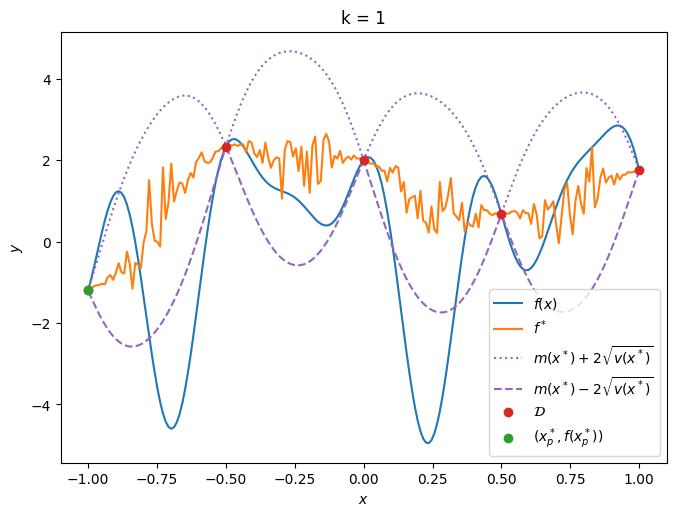

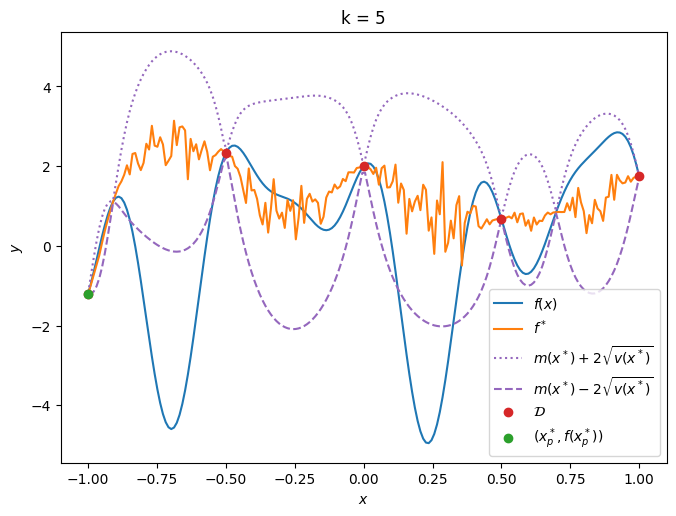

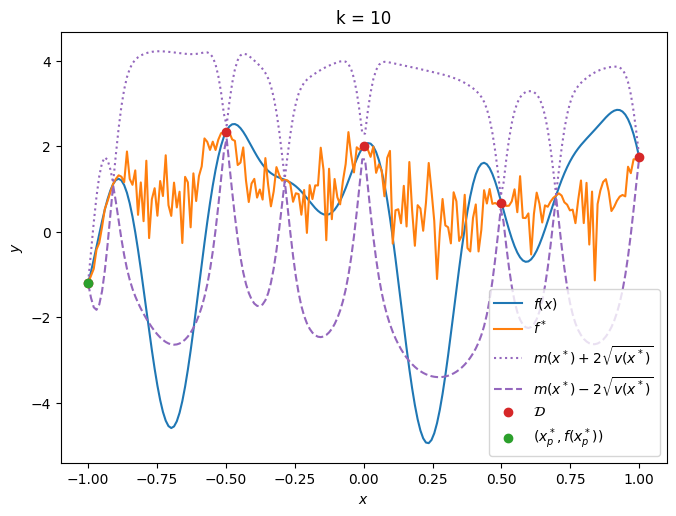

In [ ]:
prior_dict = {}
prior_dict['variance'] = pyro.nn.PyroSample(dist.LogNormal(0., 2.))
kernel = gp.kernels.Brownian(input_dim=1)
stats, minima, mcmc = algorithm1(X, y, XNew, T, C, W, N, prior_dict=prior_dict, kernel=kernel)
for k in [0, 4, 9]:
    plot_b2(X, XNew, y, stats, minima, k)

### Matern32 kernel

Iteration 1/10


Sample: 100%|██████████| 50/50 [00:01, 29.55it/s, step size=6.23e-01, acc. prob=0.848]


torch.Size([200])
Iteration 2/10


Sample: 100%|██████████| 50/50 [00:01, 32.59it/s, step size=4.34e+00, acc. prob=0.000]


torch.Size([200])
Iteration 3/10


Sample: 100%|██████████| 50/50 [00:01, 27.61it/s, step size=5.45e+00, acc. prob=0.008]


torch.Size([200])
Iteration 4/10


Sample: 100%|██████████| 50/50 [00:01, 28.73it/s, step size=1.27e+00, acc. prob=0.461]


torch.Size([200])
Iteration 5/10


Sample: 100%|██████████| 50/50 [00:02, 23.52it/s, step size=1.23e+00, acc. prob=0.083]


torch.Size([200])
Iteration 6/10


Sample: 100%|██████████| 50/50 [00:01, 32.38it/s, step size=7.16e-01, acc. prob=0.850]


torch.Size([200])
Iteration 7/10


Sample: 100%|██████████| 50/50 [00:35,  1.41it/s, step size=1.28e-01, acc. prob=0.268]


torch.Size([200])
Iteration 8/10


Sample: 100%|██████████| 50/50 [00:01, 32.07it/s, step size=2.20e+00, acc. prob=0.096]


torch.Size([200])
Iteration 9/10


Sample: 100%|██████████| 50/50 [00:01, 31.10it/s, step size=2.76e+00, acc. prob=0.004]


torch.Size([200])
Iteration 10/10


Sample: 100%|██████████| 50/50 [00:01, 25.19it/s, step size=8.52e-01, acc. prob=0.438]


torch.Size([200])


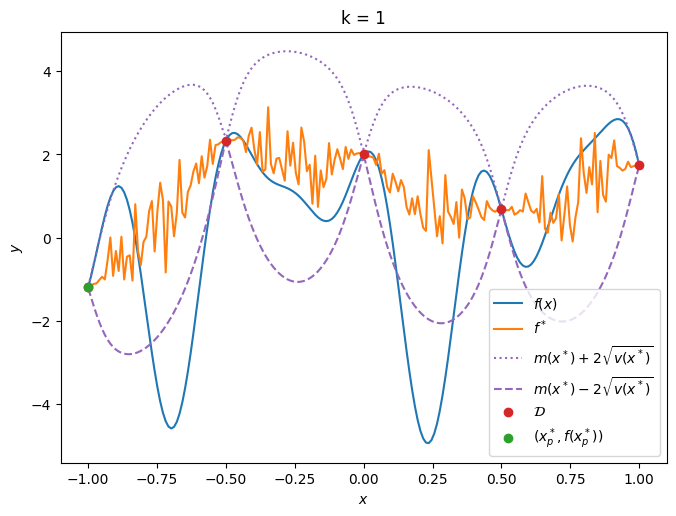

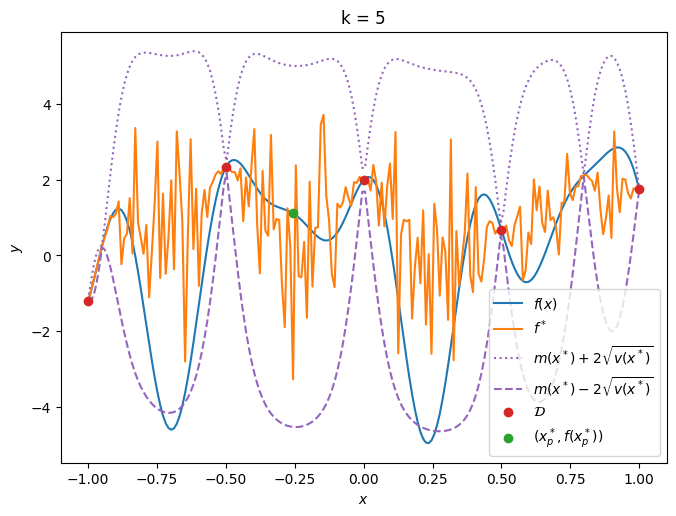

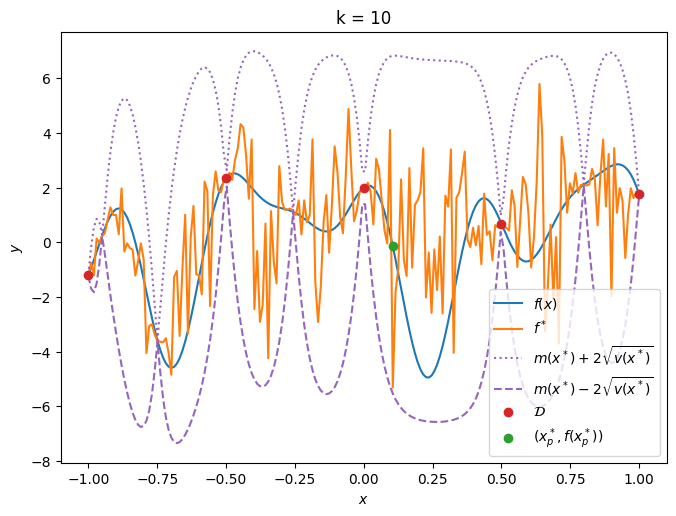

In [ ]:
prior_dict = {}
prior_dict['variance'] = pyro.nn.PyroSample(dist.LogNormal(0., 2.))
prior_dict['lengthscale'] = pyro.nn.PyroSample(dist.LogNormal(-1., 1.))
kernel = gp.kernels.Matern32(input_dim=1)
stats, minima, mcmc = algorithm1(X, y, XNew, T, C, W, N, prior_dict=prior_dict, kernel=kernel)
for k in [0, 4, 9]:
    plot_b2(X, XNew, y, stats, minima, k)


### Cosine kernel

Iteration 1/10


Sample: 100%|██████████| 50/50 [00:01, 33.98it/s, step size=2.34e+00, acc. prob=0.270]


torch.Size([200])
Iteration 2/10


Sample: 100%|██████████| 50/50 [00:01, 31.30it/s, step size=1.91e+00, acc. prob=0.012]


torch.Size([200])
Iteration 3/10


Sample: 100%|██████████| 50/50 [00:01, 35.55it/s, step size=2.45e+00, acc. prob=0.218]


torch.Size([200])
Iteration 4/10


Sample: 100%|██████████| 50/50 [00:01, 31.30it/s, step size=1.01e+00, acc. prob=0.518]


torch.Size([200])
Iteration 5/10


Sample: 100%|██████████| 50/50 [00:02, 24.86it/s, step size=1.72e+00, acc. prob=0.298]


torch.Size([200])
Iteration 6/10


Sample: 100%|██████████| 50/50 [00:02, 24.27it/s, step size=9.28e-01, acc. prob=0.432]


torch.Size([200])
Iteration 7/10


Sample: 100%|██████████| 50/50 [00:01, 35.67it/s, step size=2.28e+00, acc. prob=0.097]


torch.Size([200])
Iteration 8/10


Sample: 100%|██████████| 50/50 [00:01, 27.90it/s, step size=1.70e+00, acc. prob=0.410]


torch.Size([200])
Iteration 9/10


Sample: 100%|██████████| 50/50 [00:01, 38.71it/s, step size=5.06e+00, acc. prob=0.000]


torch.Size([200])
Iteration 10/10


Sample: 100%|██████████| 50/50 [00:01, 33.74it/s, step size=1.60e+00, acc. prob=0.337]


torch.Size([200])


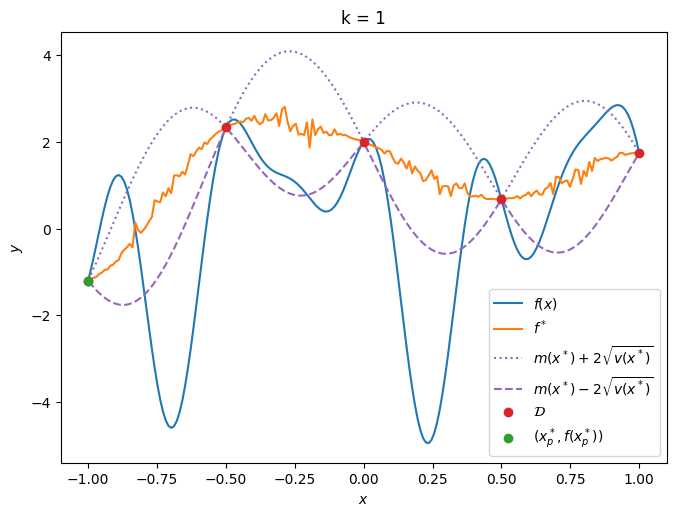

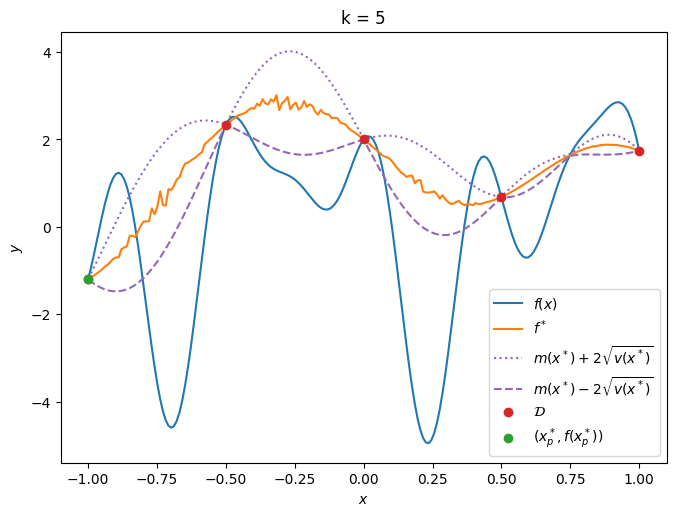

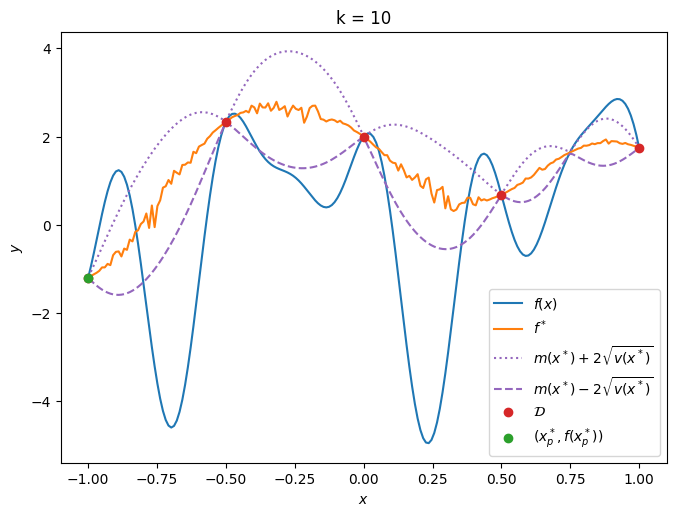

In [ ]:
prior_dict = {}
prior_dict['variance'] = pyro.nn.PyroSample(dist.LogNormal(0., 2.))
prior_dict['lengthscale'] = pyro.nn.PyroSample(dist.LogNormal(-1., 1.))
kernel = gp.kernels.Cosine(input_dim = 1)
stats, minima, mcmc = algorithm1(X, y, XNew, T, C, W, N, prior_dict=prior_dict, kernel=kernel)
for k in [0, 4, 9]:
    plot_b2(X, XNew, y, stats, minima, k)